Test main for training

In [1]:
from model import AttentionModel
from attention import trainer
from attetion_sep_size_heads import trainer_multidomain_strategyB

import os
import torch
import random
import numpy as np

In [2]:
cwd = os.getcwd()

In [3]:
def read_tensor_from_txt(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Read the dimensions from the first line
    dims = list(map(int, lines[0].strip().split()))
    
    tensor_data = []
    current_slice = []
    for line in lines[1:]:
        line = line.strip()
        if line.startswith("Slice"):
            if current_slice:
                tensor_data.append(current_slice)
                current_slice = []
        elif line:
            current_slice.append(list(map(float, line.split(','))))
    if current_slice:
        tensor_data.append(current_slice)

    tensor = torch.tensor(tensor_data).view(*dims)
    return tensor

def save_tensor_to_txt(tensor, filename):
    with open(filename, 'w') as f:
        # Write tensor dimensions
        dims = tensor.size()
        f.write(" ".join(map(str, dims)) + "\n")

        # Iterate over the first dimension (slices)
        for i in range(dims[0]):
            f.write("\n")
            f.write(f"Slice {i + 1}\n")
            for j in range(dims[1]):  # Iterate over the second dimension (rows)
                row = tensor[i, j].tolist()
                f.write(",".join(map(str, row)) + "\n")

def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(seed=0)    

In [4]:
H = 64
d= 10
n_epochs = 500 #could go more down
#domain1_end = 63 #if your protein msa input family has a domain division, this is the zero index of the last aminoacid of the first domain
domain1_end = 62


family = 'jdoms_bacteria_train2'
cwd = '/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/Attention-DCA-main'
filename = cwd + f'/CODE/DataAttentionDCA/jdoms/{family}.fasta' #new lisa for energy couplings: HKRR174
structfile = None

H1 = 22
H2 = 0# 26 + H1
trainer_type = 'std' #std_with_masks' # 'std' or 'std_with_masks' 'multidomain'
if trainer_type == 'std':
    domain1_end = 0
    H1 = H2 = 0

if trainer_type == 'multidomain':
    assert(np.mod(H-H2,2)==0) #this is to check that the number of heads is even, so that the division intersection heads and its reciprocal is not possible

In [5]:
#standard training/model with or without masks
if trainer_type == 'std' or trainer_type == 'std_with_masks':
    
    model = trainer(
        n_epochs=n_epochs,
        H=H,
        d=d,
        filename=filename,
        structfile=structfile,
        losstype='without_J',
        index_last_domain1=domain1_end,  # this value is the 0-index include the domain 1, for HK-RR is 63 (so 64 long domain 1) 
        #it is set to zero if i dont want to divide any domain
        H1 = H1,
        H2 = H2
    )

    # Create results directory
    simul_name = f'{H}_{d}_{family}_without_J_{n_epochs}'
    cwd = '/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/Attention-DCA-main'
    results_dir = cwd + f'/results/MARZIO/{simul_name}'
    os.makedirs(results_dir, exist_ok=True)

    # Save model parameters
    save_tensor_to_txt(model.Q.data, "./results/"+simul_name+"/Q_tensor.txt")
    save_tensor_to_txt(model.K.data, "./results/"+simul_name+"/K_tensor.txt")
    save_tensor_to_txt(model.V.data, "./results/"+simul_name+"/V_tensor.txt")

#multidomain training/model: each domain has its own attention block (with size specific heads) with shared interdomain attention block
if trainer_type == 'multidomain':
    other_info_mat_ene = False # give pretrained model to interdomain subblock
    model = trainer_multidomain_strategyB(n_epochs=n_epochs,
                                     H=H, d=d,
                                     batch_size=500,
                                     eta=0.005, lambd=0.001,
                                     domain1_end=domain1_end,
                                     H1 = H1,
                                     H2=H2,
                                     filename=filename,
                                     other_info_mat_ene = other_info_mat_ene)
    # Create results directory
    simul_name = f'{H}_{d}_{family}_without_J_{n_epochs}'
    results_dir = f'./results/MARZIO/{simul_name}'
    os.makedirs(results_dir, exist_ok=True)

    # Save model parameters
    save_tensor_to_txt(model.Q2.data, "./results/"+simul_name+"/Q2_tensor.txt")
    save_tensor_to_txt(model.K2.data, "./results/"+simul_name+"/K2_tensor.txt")
    save_tensor_to_txt(model.V2.data, "./results/"+simul_name+"/V2_tensor.txt")

    save_tensor_to_txt(model.Q1.data, "./results/"+simul_name+"/Q1_tensor.txt")
    save_tensor_to_txt(model.K1.data, "./results/"+simul_name+"/K1_tensor.txt")
    save_tensor_to_txt(model.V1.data, "./results/"+simul_name+"/V1_tensor.txt")

    save_tensor_to_txt(model.Qint1.data, "./results/"+simul_name+"/Qint1_tensor.txt")
    save_tensor_to_txt(model.Kint1.data, "./results/"+simul_name+"/Kint1_tensor.txt")
    save_tensor_to_txt(model.Vint1.data, "./results/"+simul_name+"/Vint1_tensor.txt")

    save_tensor_to_txt(model.Qint2.data, "./results/"+simul_name+"/Qint2_tensor.txt")
    save_tensor_to_txt(model.Kint2.data, "./results/"+simul_name+"/Kint2_tensor.txt")
    save_tensor_to_txt(model.Vint2.data, "./results/"+simul_name+"/Vint2_tensor.txt")

Total sequences read: 14502
Sequences after filtering: 14502
Sampling 100000 pairs out of 105146751 total pairs.
Mean fraction of identical positions (sampled): 0.37202728570888266
Computed theta: 0.3268577458459699


100%|██████████| 14502/14502 [00:07<00:00, 1922.74it/s]


3265.70225762244
63
Using device: cpu
Q is none
Q init
Parameter containing:
tensor([[[ 1.7641e+00,  4.0016e-01,  9.7874e-01,  ..., -6.7246e-01,
          -3.5955e-01, -8.1315e-01],
         [-1.7263e+00,  1.7743e-01, -4.0178e-01,  ...,  1.3264e+00,
          -6.9457e-01, -1.4963e-01],
         [-4.3515e-01,  1.8493e+00,  6.7229e-01,  ..., -1.1044e+00,
           5.2165e-02, -7.3956e-01],
         ...,
         [-1.1594e+00, -8.5931e-02,  1.9429e-01,  ..., -3.4242e-02,
           1.0963e+00, -2.3422e-01],
         [-3.4745e-01, -5.8127e-01, -1.6326e+00,  ..., -7.2904e-01,
           1.9656e-01,  3.5476e-01],
         [ 6.1689e-01,  8.6279e-03,  5.2700e-01,  ...,  1.6709e+00,
          -5.6133e-02, -1.3850e-03]],

        [[-6.8730e-01, -1.1747e-01,  4.6617e-01,  ...,  3.3058e-01,
           9.4925e-01, -1.5024e+00],
         [-1.7777e+00, -5.3270e-01,  1.0907e+00,  ...,  1.6962e+00,
          -1.4858e-02,  8.2141e-01],
         [ 6.7057e-01, -7.0751e-01,  3.9767e-02,  ..., -6.6771e-01,

FileNotFoundError: [Errno 2] No such file or directory: './results/64_10_jdoms_bacteria_train2_without_J_500/Q_tensor.txt'

In [6]:
os.makedirs(results_dir, exist_ok=True)
# Save model parameters
save_tensor_to_txt(model.Q.data, f"{results_dir}/Q_tensor.txt")
save_tensor_to_txt(model.K.data, f"{results_dir}/K_tensor.txt")
save_tensor_to_txt(model.V.data, f"{results_dir}/V_tensor.txt")

In [3]:
from utils import quickread

def read_tensor_from_txt(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    # Read the dimensions from the first line
    dims = list(map(int, lines[0].strip().split()))
    
    # Initialize a list to hold the tensor data
    tensor_data = []
    
    current_slice = []
    for line in lines[1:]:
        line = line.strip()
        if line.startswith("Slice"):
            if current_slice:  # If there is an existing slice, save it
                tensor_data.append(current_slice)
                current_slice = []
        elif line:  # Process non-empty lines
            current_slice.append(list(map(float, line.split(','))))
    
    if current_slice:  # Append the last slice
        tensor_data.append(current_slice)
    
    # Convert the list back into a tensor with the original dimensions
    tensor = torch.tensor(tensor_data).view(*dims)
    return tensor

family = 'jdoms_bacteria_train2'
cwd = '/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/Attention-DCA-main'
filename = cwd + f'/CODE/DataAttentionDCA/jdoms/{family}.fasta'
structfile = cwd + '/CODE/DataAttentionDCA/jdoms/jdom.dat'

Z, W = quickread(filename)
W = W / W.sum()
q = int(Z.max()) + 1
N, M = Z.shape

Total sequences read: 14502
Sequences after filtering: 14502
Sampling 100000 pairs out of 105146751 total pairs.
Mean fraction of identical positions (sampled): 0.3720411111111111
Computed theta: 0.32684559950065256


100%|██████████| 14502/14502 [00:07<00:00, 1830.11it/s]

3265.70225762244


In [4]:
H = 64
d= 10
N = 174
n_epochs = 500
loss_type = 'without_J'
cwd = '/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/Attention-DCA-main/'
Kstd_32_23 = read_tensor_from_txt( cwd +"/results/MARZIO/{H}_{d}_{family}_{losstype}_{n_epochs}_youssef/K_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
Qstd_32_23 = read_tensor_from_txt( cwd +"/results/MARZIO/{H}_{d}_{family}_{losstype}_{n_epochs}_youssef/Q_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
Vstd_32_23 = read_tensor_from_txt( cwd +"/results/MARZIO/{H}_{d}_{family}_{losstype}_{n_epochs}_youssef/V_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))

In [5]:
from dcascore import score

model = AttentionModel(H,d,N,q)
model.Q.data = Qstd_32_23
model.K.data = Kstd_32_23
model.V.data = Vstd_32_23
ranking_std_32_23, _ = score(model, Qstd_32_23, Kstd_32_23, Vstd_32_23)

not working


174


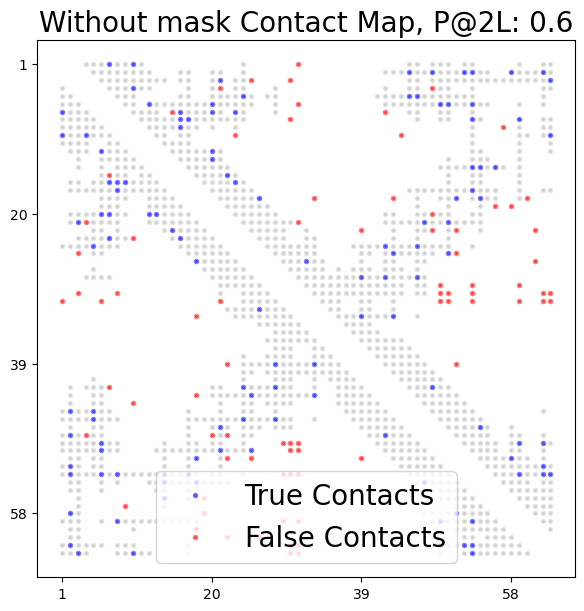

In [10]:
from plot_functions import contact_plot
ticks = np.arange(1, N+1, 19)  # Example tick positions
num = int(N)
print(N)
number_predictions = 100
# Call the contact_plot function

figurename = 'Without mask'
fake32_23_wo_mask = contact_plot(ranking_std_32_23, structfile, number_predictions, figurename, ticks=ticks, min_separation=2, cutoff=10.0, N="2L")

Generative model - ArDCA

In [ ]:
a = model.compute_attention_heads(Qstd_32_23,Kstd_32_23,Vstd_32_23)
#print(a.shape)